# LLM Reliability: Entropy Control

LLM Agents usually operate in loops or chains. If a model has a 99% success rate ($p=0.99$) for a single step, and an agent requires 10 steps to complete a task, the probability of total success drops:

$$P(\mathrm{success}) = 0.99^{10} \approx 0.90$$

If the per-step success probability decreases slightly (\( p = 0.95 \)), overall reliability drops sharply:

$$P(\mathrm{success}) = 0.95^{10} \approx 0.59$$

From this, it follows that reliability is fundamentally a probability - management problem - more precisely, a problem of managing compounding risk across decisions.


In [1]:
import math

math.pow(0.95, 10)

0.5987369392383787

## From Compounding Risk to Entropy Control

The takeaway from the probability example is not that models are unreliable, but that small amounts of ambiguity compound. Each step in an agent’s execution introduces a probability distribution over possible continuations, and any excess uncertainty at that step increases the chance of downstream failure.

Crucially, much of this uncertainty is self-inflicted. It comes from how we phrase instructions, how we define interfaces, and what we leave implicit. When a prompt, schema, or architectural choice leaves multiple plausible interpretations open, the model must distribute probability mass across them. Even if the correct path is the most likely, the remaining mass represents real risk that compounds across steps.

This reframes prompt writing and system design as a form of entropy control. The goal is not to make the model “understand better,” but to reduce the size of the space it is allowed to explore at each decision point.

Affirmative constraints are one effective way to do this—but they are not the only one. Any source of ambiguity forces the model to distribute probability mass across multiple plausible interpretations. That spread is entropy, and it represents real risk.

Whether ambiguity comes from language (“do not X”), representation (overloaded encodings), or interface design (underspecified outputs), the effect is the same: the model must guess. Even when the correct interpretation is the most likely, the remaining probability mass compounds across steps.

From this perspective, reliability improves not by clever phrasing, but by systematically eliminating ambiguity—collapsing the probability space wherever possible.


<p align="center">
  <em>A useful way to reason about LLM reliability is to think in terms of universes of possible outputs</em><br>
</p>


## Claim #1: Affirmative constraints reduce the search space (entropy) of the next-token prediction more effectively than negative constraints

**Thesis**: Affirmative prompts collapse the probability distribution; Negative prompts leave it wide open.

1. The "Don't Think of a White Bear" Problem (Attention Heads).  
   In Transformer architectures, attention mechanisms (`Attention(Q,K,V)`) work by attending to tokens that are present.

   - Mechanism: When you say "Do not use the word Apple," the self-attention mechanism attends strongly to the token embedding for "Apple".

   - The Failure Mode: The model now has "Apple" activated in its context window. It has to perform a secondary cognitive step to negate that activation. If the model is "tired" (low compute/quantized) or the context is long, it might lapse and attend to the activated token without processing the negation operator ("not").

   - Validation: Affirmative language ("Use the word Orange") activates the target token directly without requiring a negation logic gate.

2. Vector Space & Entropy Reduction
   Visualize the LLM's latent space as a vast multi-dimensional map.

   - Negative Constraint ("Do not write Python"): You are effectively saying, "Go anywhere on this map except this one coordinate." The remaining valid probability space (entropy) is massive. The model might drift into C++, Java, or even natural language prose. The probability distribution P(next_token) remains flat (high entropy).

   - Affirmative Constraint ("Write in Typescript"): You are saying, "Go to specifically this coordinate." The probability distribution peaks sharply around Typescript-related tokens. The entropy drops near zero.


3. The "Not" Token is Weak
   From a pure probability standpoint, the token "not" is often a "stop word" or easily skipped in long sequences during inference.

   - Validation: If you inspect the attention weights of a failed prompt, you will likely see high attention on the noun (the thing forbidden) and lower attention on the operator (the "not"). Affirmative phrasing removes this point of failure entirely.


In [2]:
from entropypilot.config import config
import os
import nest_asyncio
from entropypilot.utils import visualize_palette

nest_asyncio.apply()

os.environ["OPENAI_API_KEY"] = config.openai_api_key


In [3]:
neg_prompt = "Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange."
neg_prompt

'Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange.'

In [4]:
aff_prompt = "Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must ONLY contain shades of cool blues, aquas, and teals."
aff_prompt

'Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must ONLY contain shades of cool blues, aquas, and teals.'

Generating universe of 15000 random colors...


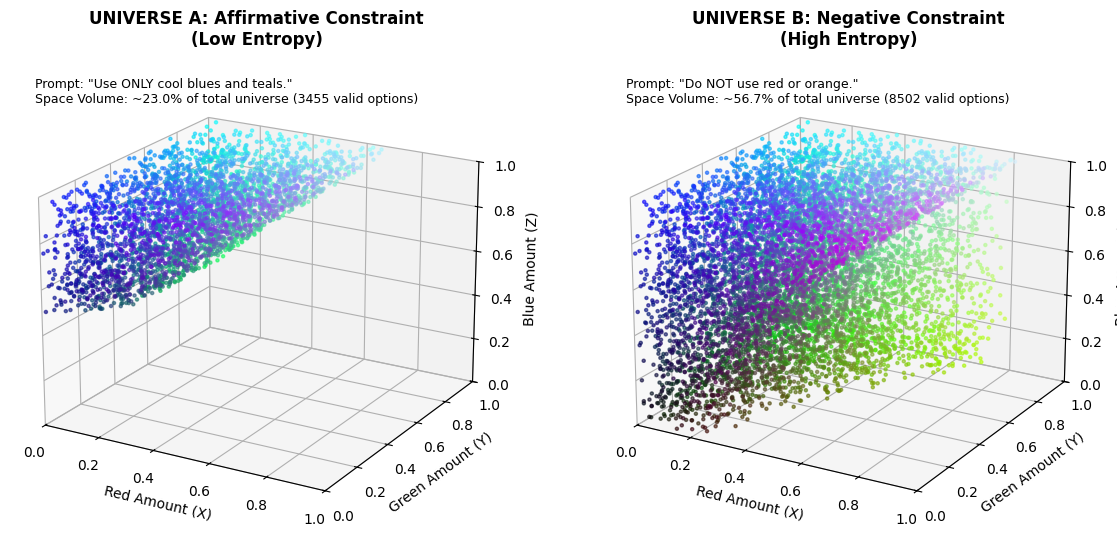

In [5]:
import matplotlib.pyplot as plt
from entropypilot.color_universe import (
    plot_universe,
    aff_universe,
    neg_universe,
)

fig = plt.figure(figsize=(14, 7))
fig.canvas.manager.set_window_title(  # type: ignore
    "Visualizing Probability Spaces: Affirmative vs Negative"
)

# --- Plot 1: Affirmative ---
ax1 = fig.add_subplot(121, projection="3d")
plot_universe(
    ax1,
    aff_universe,
    title="UNIVERSE A: Affirmative Constraint\n(Low Entropy)",
    subtitle='Prompt: "Use ONLY cool blues and teals."',
)

# --- Plot 2: Negative ---
ax2 = fig.add_subplot(122, projection="3d")
plot_universe(
    ax2,
    neg_universe,
    title="UNIVERSE B: Negative Constraint\n(High Entropy)",
    subtitle='Prompt: "Do NOT use red or orange."',
)

In [6]:
from openai import OpenAI
from entropypilot.utils.models import Colors

client = OpenAI()


def get_colors_from_llm(prompt: str, model: str = "gpt-4o-mini") -> Colors:
    """
    Calls the LLM and demands a raw JSON list of hex codes.
    """
    try:
        completion = client.chat.completions.parse(
            model=model,
            response_format=Colors,
            messages=[
                {
                    "role": "system",
                    "content": "You are a color palette generator. Output only raw JSON lists of 6 hex codes under the key 'palette'.",
                },
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.parsed or Colors(palette=["#cccccc"] * 6)
    except Exception as e:
        print(f"Error generating colors: {e}")
        # Return a fallback gray palette if LLM fails entirely
        return Colors(palette=["#cccccc"] * 6)


Generate a palette of 6 distinct hex codes. CONSTRAINT: The palette must NOT contain any shade of red or orange.


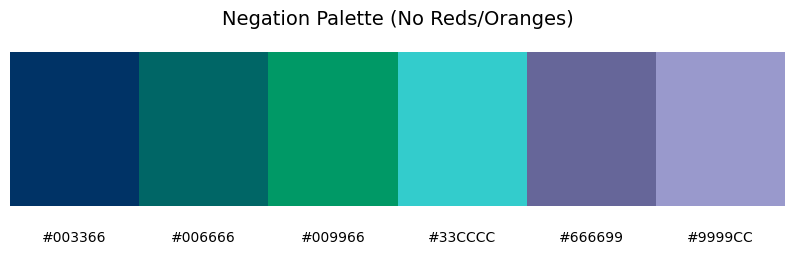

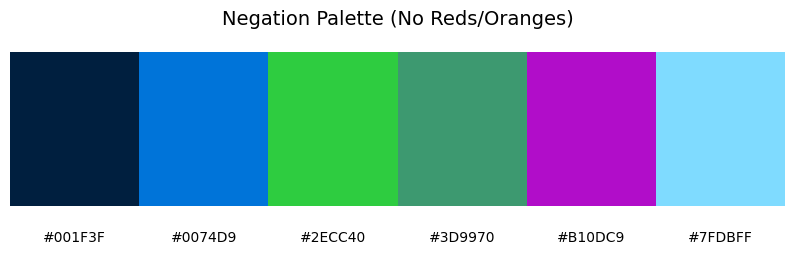

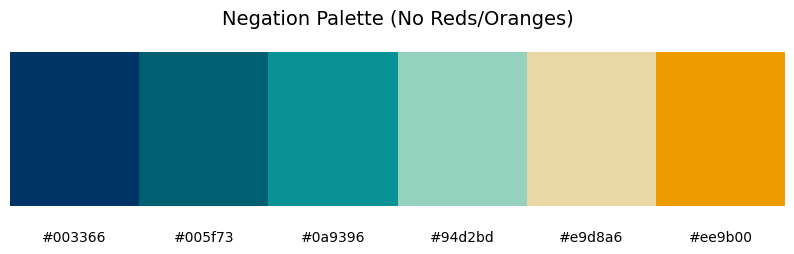

In [10]:
print(neg_prompt)

for i in range(3):
    neg_colors = get_colors_from_llm(neg_prompt, model="gpt-5.1")
    if neg_colors:
        visualize_palette(neg_colors.palette, "Negation Palette (No Reds/Oranges)")

The above is high entropy. The model had to consider the entire universe of colors and try to apply a 'not red' filter. That filter is leaky.


In [ ]:
for i in range(3):
    aff_prompt_colors = get_colors_from_llm(aff_prompt, model="gpt-4o-mini")

    if aff_prompt_colors:
        visualize_palette(
            aff_prompt_colors.palette, "Affirmative Palette (Only Blues/Aquas/Teals)"
        )

This is low entropy. We architected the prompt to collapse the search space instantly. Reliability isn't about linguistic cleverness; it's about reducing the mathematical space where errors can occur.


In [ ]:
num_runs = 100

# Statistics tracking
stats = {
    "negative": {
        "total_runs": 0,
        "runs_with_violations": 0,
        "total_colors": 0,
        "violation_colors": 0,
        "violation_examples": [],  # Store some examples of violations
        "all_palettes": [],  # Store all generated palettes
        "all_violations": [],  # Store violation status per color
    },
    "affirmative": {
        "total_runs": 0,
        "runs_with_violations": 0,
        "total_colors": 0,
        "violation_colors": 0,
        "violation_examples": [],
        "all_palettes": [],
        "all_violations": [],
    },
}

In [ ]:
from entropypilot.simulation import (
    is_red_or_orange,
    is_cool_blue_aqua_teal,
    plot_color_palettes,
    plot_results_graph,
)


for i in range(num_runs):
    if (i + 1) % 10 == 0 or i == 0:
        print(f"Run {i + 1}/{num_runs}...")

    # Test negative constraint
    neg_colors = get_colors_from_llm(neg_prompt, model="gpt-4o-mini")
    if neg_colors:
        stats["negative"]["total_runs"] += 1
        stats["negative"]["total_colors"] += len(neg_colors.palette)
        stats["negative"]["all_palettes"].append(neg_colors.palette)
        violation_mask = [is_red_or_orange(c) for c in neg_colors.palette]
        stats["negative"]["all_violations"].append(violation_mask)
        violations = [c for c, v in zip(neg_colors.palette, violation_mask) if v]
        if violations:
            stats["negative"]["runs_with_violations"] += 1
            stats["negative"]["violation_colors"] += len(violations)
            if len(stats["negative"]["violation_examples"]) < 10:
                stats["negative"]["violation_examples"].append(
                    {
                        "run": i + 1,
                        "palette": neg_colors.palette,
                        "violations": violations,
                    }
                )

    # Test affirmative constraint
    aff_colors = get_colors_from_llm(
        aff_prompt,
        model="gpt-4o-mini",
    )
    if aff_colors:
        stats["affirmative"]["total_runs"] += 1
        stats["affirmative"]["total_colors"] += len(aff_colors.palette)
        stats["affirmative"]["all_palettes"].append(aff_colors.palette)
        violation_mask = [not is_cool_blue_aqua_teal(c) for c in aff_colors.palette]
        stats["affirmative"]["all_violations"].append(violation_mask)
        violations = [c for c, v in zip(aff_colors.palette, violation_mask) if v]
        if violations:
            stats["affirmative"]["runs_with_violations"] += 1
            stats["affirmative"]["violation_colors"] += len(violations)
            if len(stats["affirmative"]["violation_examples"]) < 10:
                stats["affirmative"]["violation_examples"].append(
                    {
                        "run": i + 1,
                        "palette": aff_colors.palette,
                        "violations": violations,
                    }
                )


plot_color_palettes(stats, max_palettes=100)
plot_results_graph(stats)

## Entropy Isn’t Just Linguistic — It’s Structural

The same entropy dynamics apply beyond natural language. Ambiguity introduced by data representation or interface design expands the model’s search space in exactly the same way as ambiguous prompts.

To illustrate this, consider a simple example: representing a player’s height.

### Height Encoding: Ambiguity by Design


In [ ]:
{"height": 510}

- Is this 5′10″?
- Is it 510 cm?
- Is it 510 inches?
- Is it $feet × 100 + inches$?
- Is it an internal encoding convention?

The model must infer intent. Probability mass spreads.


In [ ]:
{"height": {"feet": 5, "inches": 10}}

- One interpretation
- No decoding step
- No convention guessing
- No inverse mapping required

Key line to land the point:

This isn’t about making the model smarter — it’s about removing degrees of freedom.


Every ambiguous decision point expands the universe of possible outcomes; reliability is the discipline of collapsing that universe before the model ever has to choose.


Reliability emerges when we design systems that minimize the number of valid worlds the model can inhabit.
